In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import pearsonr

In [2]:
# set default style
from matplotlib import rcParams
sns.set(rc={'figure.figsize':(12,5)})
rcParams['figure.figsize'] = 12,5

# Data Processing

In [3]:
df = pd.read_csv('./data/modeldata.csv', sep='|')
df.drop_duplicates(inplace=True)
print(df.shape)
df.head()

(66192, 21)


,failure,model,date,serial_number,smart_1_raw,smart_2_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,...,smart_9_raw,smart_10_raw,smart_11_raw,smart_12_raw,smart_13_raw,smart_15_raw,smart_22_raw,smart_16_raw,smart_17_raw,smart_18_raw
0,0,Hitachi HDS5C3030ALA630,2016-01-01,MJ0351YNG9Z0XA,0,108,540,14,0.0,0.000000e+00,...,27929,0,0,14,0,0,0,5,0,654690
2,0,ST4000DM000,2016-01-01,Z305B2QN,54551400,0,0,4,0.0,1.112537e-308,...,411,0,0,4,0,0,0,4,0,654313
4,0,Hitachi HDS5C3030ALA630,2016-01-01,MJ0351YNG9Z7LA,0,104,566,19,0.0,0.000000e+00,...,27492,0,0,18,0,0,0,8,1,655582
6,0,Hitachi HDS5C3030ALA630,2016-01-01,MJ0351YNGABYAA,0,104,507,15,0.0,0.000000e+00,...,26640,0,0,15,0,0,0,7,1,654306
7,0,WDC WD30EFRX,2016-01-01,WD-WMC4N2899475,0,0,6250,10,0.0,0.000000e+00,...,12198,0,0,10,0,0,0,7,1,653592


In [4]:
# check presence of null values
df.isnull().sum()

failure          0
model            0
date             0
serial_number    0
smart_1_raw      0
smart_2_raw      0
smart_3_raw      0
smart_4_raw      0
smart_5_raw      0
smart_7_raw      0
smart_8_raw      0
smart_9_raw      0
smart_10_raw     0
smart_11_raw     0
smart_12_raw     0
smart_13_raw     0
smart_15_raw     0
smart_22_raw     0
smart_16_raw     0
smart_17_raw     0
smart_18_raw     0
dtype: int64

<div class="alert alert-info"> 
    No null values observed in dataset.
</div>

In [5]:
# check number of unique values in each feature
cols = [col for col in df.columns if 'smart' in col]
df[cols].nunique()

smart_1_raw     38139
smart_2_raw        72
smart_3_raw      1350
smart_4_raw       244
smart_5_raw       389
smart_7_raw     37521
smart_8_raw        22
smart_9_raw      6494
smart_10_raw        8
smart_11_raw      293
smart_12_raw      165
smart_13_raw        2
smart_15_raw        1
smart_22_raw        2
smart_16_raw       18
smart_17_raw        6
smart_18_raw     4528
dtype: int64

In [6]:
# only one non-zero value in smart_13, this shall be dropped
df['smart_13_raw'].value_counts()

0       66191
1187        1
Name: smart_13_raw, dtype: int64

In [7]:
# drop features with constant value
df.drop(columns=['smart_15_raw', 'smart_13_raw'], inplace=True)

<div class="alert alert-info"> 
    Smart_15 and Smart_13 are dropped due to constant readings
</div>

In [8]:
df['failure'].value_counts() / len(df) * 100

0    99.690295
1     0.309705
Name: failure, dtype: float64

<div class="alert alert-info"> 
    Imbalanced Class Situation. Only 0.3% of dataset accounted for Failure Class.<br/>
    Consider F1 as model performance instead of accuracy. <br/>
    Apply SMOTE or oversampling techniques if model performance is bad.
</div>

In [9]:
cols = [col for col in df.columns if 'smart' in col]
des_info = df.describe().transpose()
des_info['min_excl_zero'] = df.replace(0, np.nan).min()
des_info

,count,mean,std,min,25%,50%,75%,max,min_excl_zero
failure,66192.0,3.097051e-03,5.556533e-02,0.000000,0.0,0.000000e+00,0.000000e+00,1.000000e+00,1
smart_1_raw,66192.0,6.638136e+07,7.850271e+07,0.000000,0.0,3.111938e+07,1.266351e+08,8.798246e+08,1
smart_2_raw,66192.0,2.947158e+01,4.641397e+01,0.000000,0.0,0.000000e+00,9.900000e+01,1.960000e+02,68
smart_3_raw,66192.0,3.667877e+02,1.113131e+03,0.000000,0.0,0.000000e+00,5.200000e+02,9.683000e+03,100
smart_4_raw,66192.0,1.331188e+01,1.546814e+02,1.000000,3.0,6.000000e+00,1.500000e+01,2.667400e+04,1
smart_5_raw,66192.0,1.678040e+00,9.627608e+01,-29.233785,0.0,0.000000e+00,0.000000e+00,1.609600e+04,-29.2338
smart_7_raw,66192.0,6.352331e-309,0.000000e+00,0.000000,0.0,1.112537e-308,1.112537e-308,1.182070e-308,1.11254e-308
smart_8_raw,66192.0,1.153448e+01,1.827322e+01,0.000000,0.0,0.000000e+00,3.700000e+01,6.800000e+01,18
smart_9_raw,66192.0,1.399306e+04,1.288165e+04,4.000000,2702.0,1.158000e+04,2.024100e+04,8.867900e+04,4
smart_10_raw,66192.0,2.277444e+01,2.610109e+03,0.000000,0.0,0.000000e+00,0.000000e+00,3.932160e+05,1


<div class="alert alert-info"> 
    Observed Extreme Outliers, High Variance and High Percentage of 0 values for most of the variables.
    <br/>Techniques to be applied:
  <ul>
    <li>Log Transformation to Features with High Variance</li>
    <li>Upper Boundary Cap to Features with Extreme Outlier</li>
    <li>Binary Transformation to Features with only 2 clustering points</li>
  </ul>
</div>

In [10]:
# log_transformation
col_log_transform = ['smart_1_raw']
df[col_log_transform] = np.log(df[col_log_transform] + 1)

# outlier cap
col_cap_transform = ['smart_4_raw', 'smart_12_raw']
for col in col_cap_transform:
    df.loc[df[col] > df[col].quantile(0.995), col] = df[col].quantile(0.995)

# binary transformation
col_binary_transform = ['smart_10_raw', 'smart_11_raw', 'smart_22_raw']
for col in col_binary_transform:
    df[col] = df[col].apply(lambda x: 1 if x > 0 else 0)
df[col] = df[[col]].astype('category')

df['smart_7_raw'] = df['smart_7_raw'] / df['smart_7_raw'].max()

# Feature Importance and Selection

## SelectKBest Through Chi2

In [13]:
from sklearn.feature_selection import SelectKBest, chi2

In [14]:
x, y = df[cols].copy(), df['failure'].copy()
x['smart_5_raw'] = x['smart_5_raw']. apply(lambda x: '-ve' if x < 0 else('zero' if x == 0 else '+ve'))
x = pd.concat([x.drop('smart_5_raw', axis=1), 
               pd.get_dummies(x['smart_5_raw'], prefix='smart_5', drop_first=True)], axis=1)

In [24]:
# SelectKBest class to extract top 10 best features 
kbest = SelectKBest(score_func=chi2, k='all')
best_feat = kbest.fit(x, y)
df_scores = pd.DataFrame({'features' : x.columns, 
                         'score' : best_feat.scores_})
df_scores.sort_values('score', ascending=False).head(5)

,features,score
6,smart_9_raw,436653.780435
14,smart_5_-ve,53755.263415
2,smart_3_raw,11386.128949
1,smart_2_raw,4253.811271
5,smart_8_raw,1643.978060


## Feature Importance through Tree Classfier

In [16]:
from sklearn.ensemble import ExtraTreesClassifier

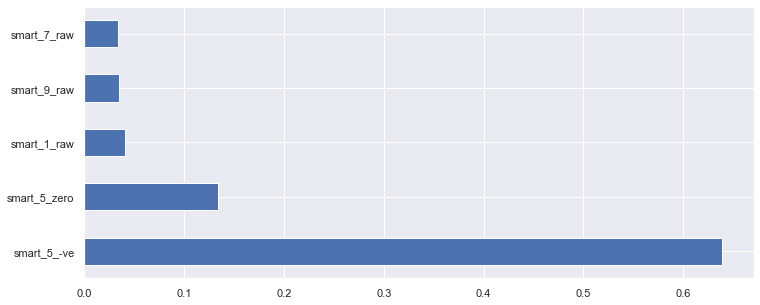

In [25]:
model = ExtraTreesClassifier()
model.fit(x,y)

feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

<div class="alert alert-info"> 
    From both approaches, smart_9 and smart_5 are ranked as the top 5 most important contributing factors to failures.
</div>

# Exploratory Analysis

In [12]:
# failure rate according to manufacturer
df['model'] = df['model'].str.replace('ST', 'ST ')
df['brand'] = df['model'].apply(lambda x: x.split()[0])
brand_failure = df.groupby('brand').count()[['serial_number']]
brand_failure.columns = ['total_counts']
brand_failure['failure_counts'] = df[df['failure'] == 1].groupby('brand').count()[['serial_number']]
brand_failure['% failure'] = (brand_failure['failure_counts']/brand_failure['total_counts']) * 100
brand_failure.fillna(0, inplace=True)
brand_failure = brand_failure.sort_values('% failure').reset_index()
brand_failure

,brand,total_counts,failure_counts,% failure
0,SAMSUNG,1,0.0,0.000000
1,HGST,12140,3.0,0.024712
2,Hitachi,12747,21.0,0.164745
3,ST,38530,154.0,0.399689
4,TOSHIBA,242,2.0,0.826446
5,WDC,2532,25.0,0.987362


[Text(0, 0.5, '% Failure'), Text(0.5, 0, 'Manufacturer')]

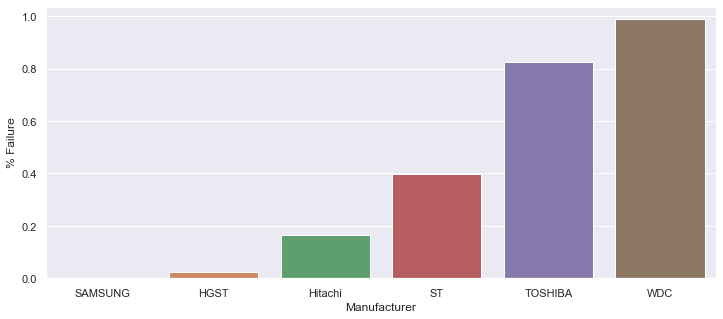

In [13]:
ax = sns.barplot(x='brand',y='% failure',data=brand_failure);
ax.set(xlabel='Manufacturer', ylabel='% Failure')

<div class="alert alert-info"> 
    HCST is the most reliable manufacturer with the lowest failure rate, followed by Hitachi, ST and WDC.
    <br/> Toshiba and Samsung are excluded due to low sample count.
</div>

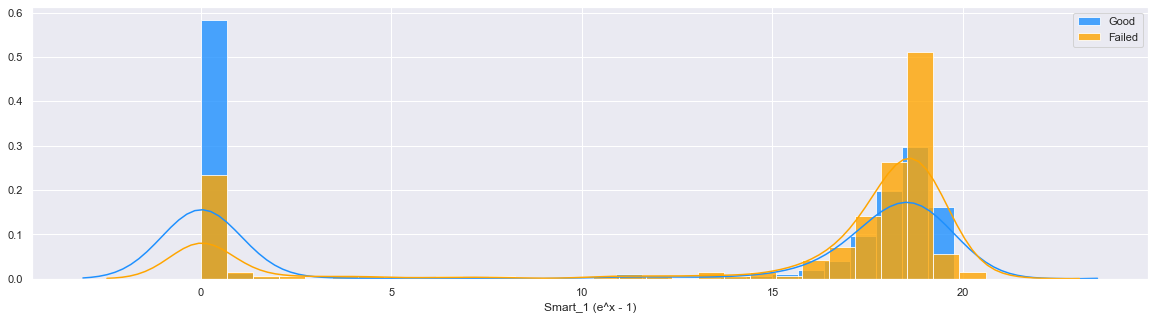

In [37]:
# distribution shift between 2 classes
plt.figure(figsize=(20,5))
sns.distplot(df[df['failure'] == 0]['smart_1_raw'], color="dodgerblue", bins=30, hist_kws={'alpha':.8}, label='Good');
sns.distplot(df[df['failure'] == 1]['smart_1_raw'], color="orange", bins=30, hist_kws={'alpha':.8}, label='Failed');
plt.xlabel('Smart_1 (e^x - 1)')
plt.legend();

<div class="alert alert-info"> 
    From the observations, smart_1_raw is having bimodal distribution, showing distinct peak at <b>0</b> or <b>~e^18</b>. <br/> 
    However, failed parts are demonstrating much higher density at <b>~e^18</b> as compared to good parts. <br/>
    It is reasonanable to say that, <b>0</b> reading of smart_1_raw gives lower risk of failure.
</div>

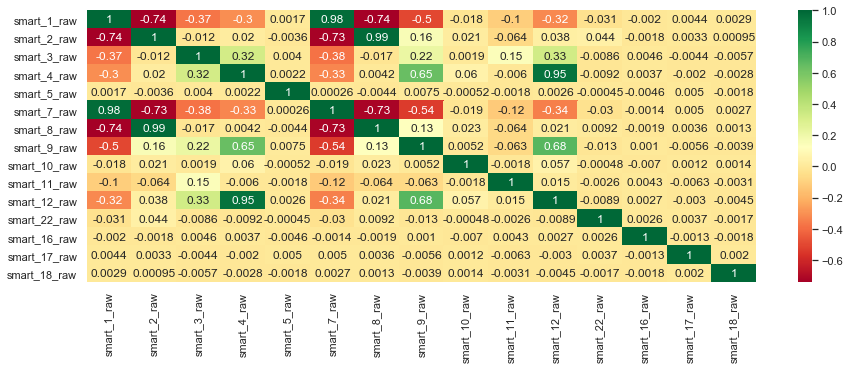

In [29]:
plt.figure(figsize=(15, 5))
sns.heatmap(df[cols].corr(), annot=True, cmap="RdYlGn")

(0.9925785282906403, 0.0)


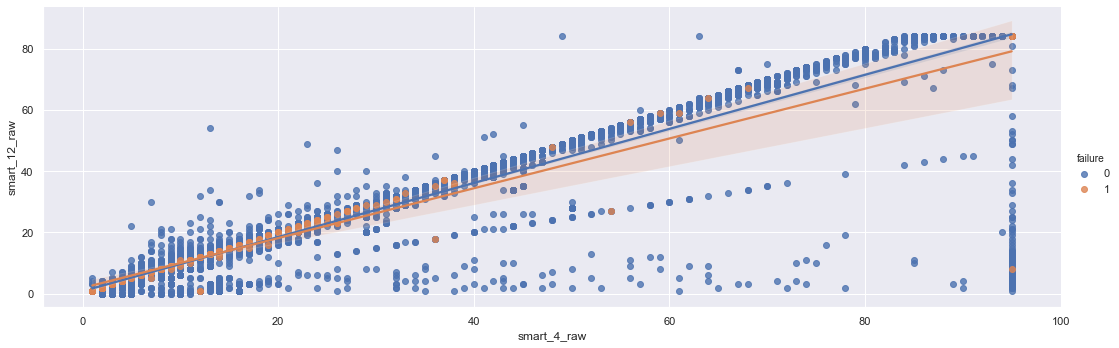

In [30]:
sns.lmplot(x='smart_4_raw', y='smart_12_raw', data=df, hue='failure', height=5, aspect=3);
print(pearsonr(df['smart_2_raw'], df['smart_8_raw']))

<div class="alert alert-info"> 
    Strong linear correlation observed between [smart_4, smart_12], [smart_1, smart_7] and [smart_2, smart_8]. <br/>
    We should remove one of them from each group to reduce multicollinearity.
</div>

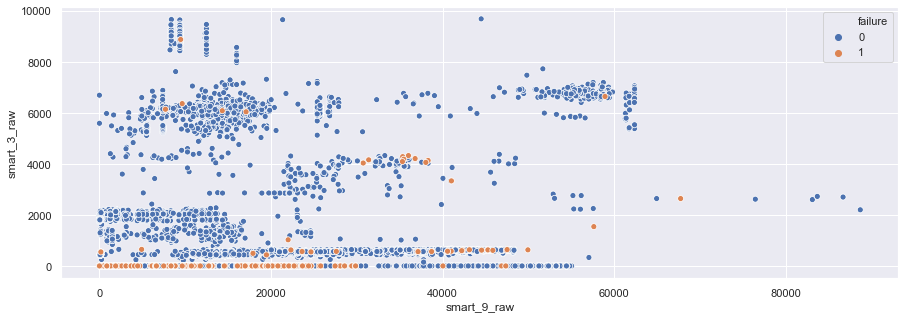

In [31]:
plt.figure(figsize=(15, 5))
sns.scatterplot(x='smart_9_raw', y='smart_3_raw', data=df, hue='failure');

<div class="alert alert-info"> 
    It can be observed most of the failures clustered at the level of 0 for smart_3, and [0, 3000] for smart_9
</div>

In [32]:
# proportion of data for each class
df_raw = df.copy()
df_raw['smart_5_raw'] = df_raw['smart_5_raw'].apply(lambda x: '-ve' if x < 0 else('zero' if x == 0 else '+ve'))
df_raw['smart_5_raw'].value_counts() / len(df)

zero    0.983699
+ve     0.013778
-ve     0.002523
Name: smart_5_raw, dtype: float64

In [33]:
# failure rate for each category
smart_5_failures = df_raw.groupby('smart_5_raw').count()[['serial_number']]
smart_5_failures.columns = ['total_counts']
smart_5_failures['failure_counts'] = df_raw[df_raw['failure'] == 1].groupby('smart_5_raw').count()[['serial_number']]
smart_5_failures['% failure'] = (smart_5_failures['failure_counts']/smart_5_failures['total_counts']) * 100
smart_5_failures.fillna(0, inplace=True)
smart_5_failures = smart_5_failures.sort_values('% failure').reset_index()
smart_5_failures.head()

,smart_5_raw,total_counts,failure_counts,% failure
0,zero,65113,0.0,0.000000
1,+ve,912,38.0,4.166667
2,-ve,167,167.0,100.000000


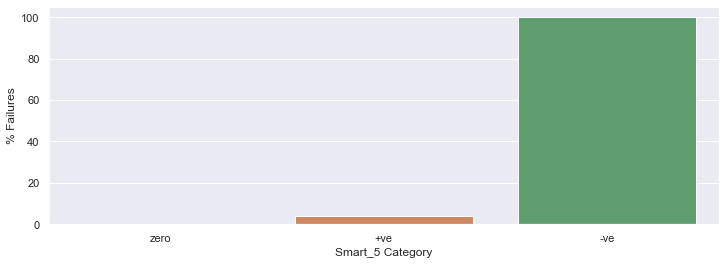

In [34]:
# failure rate for each class
plt.figure(figsize=(12,4))
ax = sns.barplot(x='smart_5_raw', y='% failure', data=smart_5_failures);
ax.set(xlabel='Smart_5 Category', ylabel='% Failures');

<div class="alert alert-info"> 
    To enhance the visualization, the readings in <b>smart_5_raw</b> are classified into 3 classes:
    <ol>
        <li>'zero' : For 0 values</li>
        <li>'-ve' : For reading smaller than 0 </li>
        <li>'+ve' : For reading larger than 0</li>
    </ol>
    It's interesting to find out that, 98% of the row fall into <b>zero</b> category, yet not a single failure is observed. <br/>
    Apart from that, 100% of the data with -ve readings has failed. <br/>
    Only ~4% of the +ve reading is classified under failure class. <br/>
    We can confidently say that, the part is very likely to fail if the reading is negative, but totally not if the values are 0.
    
</div>

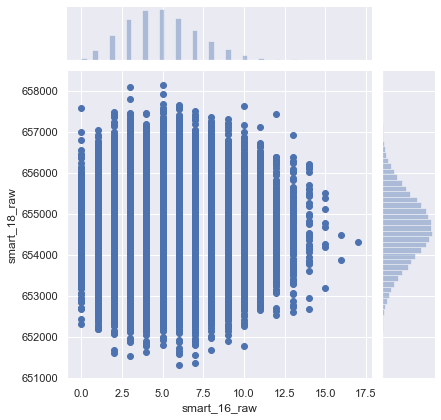

In [38]:
sns.jointplot(x=df['smart_16_raw'], y=df['smart_18_raw'], data=df, kind='scatter');

<div class="alert alert-info"> 
    Both smart_16 and smart_18 are demonstrating Gaussian distribution, which is good for statistical modelling.
</div>

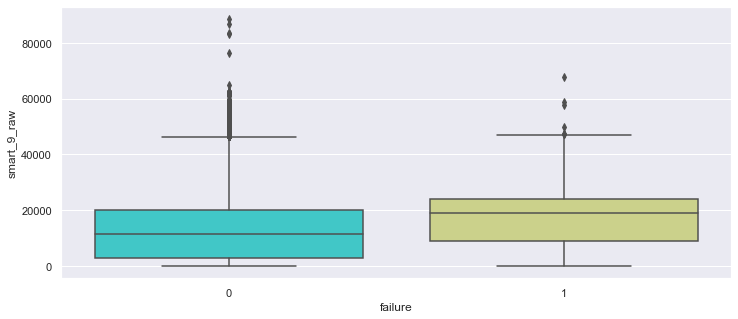

In [39]:
sns.boxplot(x='failure', y='smart_9_raw', data=df, palette='rainbow');

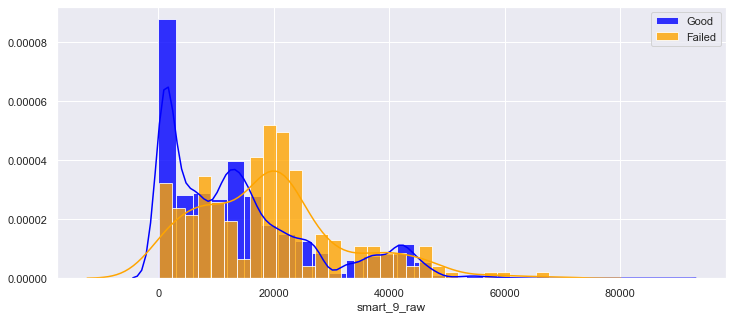

In [40]:
sns.distplot(df[df['failure'] == 0]['smart_9_raw'], color="blue", bins=30, hist_kws={'alpha':.8}, label='Good');
sns.distplot(df[df['failure'] == 1]['smart_9_raw'], color="orange", bins=30, hist_kws={'alpha':.8}, label='Failed');
plt.legend()

<div class="alert alert-info"> 
    The chart reflected the variation in distribution of smart_9 for class 0 and 1. <br/>
    They possess different values for measures of centre, kurtosis and skewness. <br/>
    The shift of distribution indicates smart_9 is a contributing factor to failure, with the peak at 2000.
</div>

# Outlier Detection

In [41]:
from sklearn.neighbors import LocalOutlierFactor

In [42]:
lof = LocalOutlierFactor(20, p=1, contamination=0.10, n_jobs=-1)
lof_mask = lof.fit_predict(df[cols])
df_out = df.loc[lof_mask != 1]

In [43]:
# number of failures in 10% dataset
df_out['failure'].value_counts()

0    6500
1     120
Name: failure, dtype: int64

In [44]:
# number of failures in full dataset
df['failure'].value_counts()

0    65987
1      205
Name: failure, dtype: int64

<div class="alert alert-info"> 
    By setting the contamination at 10%, the proportion of the dataset are classfied as outliers through measuring local deviation of density of a sample with respect to its neighbors. <br/>
    With merely 10% of dataset, these outliers accounted for 58% of the failures (120 out of 205). <br/>
    It is rational to make the assumption that anomalies are more prone to failure.
</div>

# Model Training

In [45]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, confusion_matrix,  classification_report

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [46]:
X, y = df[cols], df['failure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 99)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [51]:
# applying GridSearch to find the best parameters
lg = lgb.LGBMClassifier(silent=False)
param_dist = {"max_depth": [25,50, 75],
              "learning_rate" : [0.01,0.05,0.1],
              "num_leaves": [300,900,1200],
              "n_estimators": [200]
             }

grid_search = GridSearchCV(lg, n_jobs=-1, param_grid=param_dist, cv=3, scoring="roc_auc", verbose=0)
grid_search.fit(X_train,y_train)
print(grid_search.best_estimator_)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=25,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=300, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [52]:
# model fitting
d_train = lgb.Dataset(X_train, label=y_train)
params = {"max_depth": 25, "learning_rate" : 0.05, "num_leaves": 300,  "n_estimators": 200}
# Without Categorical Features
clf_lgb = lgb.train(params, d_train)

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [53]:
# prediction and evaluation
predictions = clf_lgb.predict(X_train)
y_pred = (predictions > 0.5) * 1
cm = confusion_matrix(y_train, y_pred)
print(pd.DataFrame(cm, columns = ['Predicted -', 'Predicted +'], index = ['Actual -', 'Actual +']))
print(classification_report(y_train,y_pred))

          Predicted -  Predicted +
Actual -        49485            2
Actual +            5          152
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49487
           1       0.99      0.97      0.98       157

    accuracy                           1.00     49644
   macro avg       0.99      0.98      0.99     49644
weighted avg       1.00      1.00      1.00     49644



<div class="alert alert-info"> 
    The Training Loss is low. It could be overfitting. <br/>
    Let's see how's the performance for testing set.
</div>

In [55]:
# prediction and evaluation
predictions = clf_lgb.predict(X_test)
y_pred = (predictions > 0.5) * 1
cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(cm, columns = ['Predicted -', 'Predicted +'], index = ['Actual -', 'Actual +']))
print(classification_report(y_test,y_pred))

          Predicted -  Predicted +
Actual -        16499            1
Actual +            3           45
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16500
           1       0.98      0.94      0.96        48

    accuracy                           1.00     16548
   macro avg       0.99      0.97      0.98     16548
weighted avg       1.00      1.00      1.00     16548



<div class="alert alert-info"> 
    The model gives good performance, proving that the Light GBM is capable in classifying the failure class based on the variables. <br/>
    No further feature selection, feature transformation or parameters tuning is needed.
</div>

The End